In [52]:
#config
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

config = {
'DEVICE' : 'cuda',
'TRAIN_DIR' :  '../input/pix2pix-dataset/maps/maps/train',
'VAL_DIR' : '../input/pix2pix-dataset/maps/maps/val',
'LEARNING_RATE' : 2e-4,
'BATCH_SIZE' : 16,
'NUM_WORKERS' : 2,
'IMAGE_SIZE' : 256,
'CHANNELS_IMG' : 3,
'L1_LAMBDA' : 100,
'LAMBDA_GP' : 10,
'NUM_EPOCHS' : 100,
'LOAD_MODEL' : False,
'SAVE_MODEL' :  False,
'CHECKPOINT_DISC' : './discriminator',
'CHECKPOINT_GEN' : './generator'}

both_transform = A.Compose([A.Resize(width=256, height=256)], additional_targets={'image0':'image'})
transform_only_input = A.Compose([A.HorizontalFlip(0.5),
                                  A.ColorJitter(p=0.2),
                                  A.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5],max_pixel_value=255.0),
                                 ToTensorV2()])
transform_only_mask = A.Compose([A.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5], max_pixel_value=255.0),
                                ToTensorV2()])



In [53]:
# dataset
import numpy as np
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image


class MapDataSet(Dataset):
    def __init__(self, path):
        self.path = path
        self.list_files = os.listdir(path)
            
    def __len__(self):
        return len(self.list_files)
     
    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.path, img_file)
        image = np.array(Image.open(img_path))
        input_image = image[:, :600, :]
        target_image = image[:, 600:, :]
        
        augmentations = both_transform(image=input_image, image0=target_image)
        input_image = augmentations['image']
        target_image = augmentations['image0']
        
        input_image = transform_only_input(image=input_image)['image']
        target_image = transform_only_mask(image=target_image)['image']
        
        return input_image, target_image
        
if __name__ == '__main__':
    dataset = MapDataSet('../input/pix2pix-dataset/maps/maps/train')
    loader = DataLoader(dataset, batch_size=3)

In [54]:
# Discriminator
# concatenated x and y because the input and output images are combined in a single image
# also, that's why inp_channels*2 in Conv2d layer
import torch 
import torch.nn as nn
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels,stride=2):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2))
        
    def forward(self, x):
        return self.conv(x)
    
class Discriminator(nn.Module):
    
    def __init__(self, in_channels, features=[64,128,256,512]): #256 -> 30x30
        super().__init__()
        self.initial = nn.Sequential(
        nn.Conv2d(in_channels*2,features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
        nn.LeakyReLU(0.2)
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature==features[-1] else 2),
            )
            in_channels = feature
            
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )
        self.model = nn.Sequential(*layers)    
    
    def forward(self, x, y):
        x = torch.cat([x,y], dim=1)
        x = self.initial(x)
        return self.model(x)
    
def test():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x, y)
    print(model)
    print(preds.shape)


if __name__ == "__main__":
    test()
    
    

Discriminator(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): Batc

In [55]:
# Generator

# Similar to UNet
# down specifies downward part of UNet
# Encoder LeakyReLU, decoder ReLU
# dont use batchnorm in initial layer
# bias=False because we are using BatchNorm
# output image of init has dimensions 128, as (n-f+2p/s)+1 => (256-4+2)/2 + 1 => 128

import torch 
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, padding_mode='reflect')
        if down
        else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act =='relu' else nn.LeakyReLU(0.2),   
        )
        
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down
        
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels,features, 4, 2, 1, padding_mode='reflect' ),
            nn.LeakyReLU(0.2))
        self.down1 = Block(features, features*2, down=True, act='leaky', use_dropout=False) #64x64
        self.down2 = Block(features*2, features*4, down=True, act='leaky', use_dropout=False) #32x32
        self.down3 = Block(features*4, features*8, down=True, act='leaky', use_dropout=False) #16x16
        self.down4 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) #8x8
        self.down5 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) #4x4
        self.down6 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) #2x2
        
        self.bottleneck = nn.Sequential(nn.Conv2d(features*8, features*8, 4, 2, 1), nn.ReLU()) #1x1
        
        self.up1 = Block(features*8, features*8, down=False, act='relu', use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up5 = Block(features*8*2, features*4, down=False, act='relu', use_dropout=True)
        self.up6 = Block(features*4*2, features*2, down=False, act='relu', use_dropout=True)
        self.up7 = Block(features*2*2, features, down=False, act='relu', use_dropout=True)
        self.final_up = nn.Sequential(nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),)
        
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))
def test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print(preds.shape)


if __name__ == "__main__":
    test()

torch.Size([1, 3, 256, 256])


In [58]:
# utils
import torch
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y =next(iter(val_loader))
    x, y = x.to(config['DEVICE']), y.to(config['DEVICE'])
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5 #removing normalization
        save_image(y_fake, folder + f'/y_gen_{epoch}.png')
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f'/label_{epoch}.png' )
    gen.train()        
        
def save_checkpoint(model, optimizer, filename='my_checkpoint.pth.tar'):
    print('=> Saving Checkpoint')
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)
    
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print('=> Loading checkpoint')
    checkpoint = torch.load(checkpoint_file, map_location=config['DEVICE'])
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    

In [62]:
# train

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image
torch.backends.cudnn.benchmark = True

def train_fn(disc, gen, loader, opt_disc,opt_gen, l1_loss, bce, g_scaler, d_scaler):
    loop = tqdm(loader, leave=True)
    
    for idx, (x,y) in enumerate(loop):
        x = x.to(config['DEVICE'])
        y = y.to(config['DEVICE'])
        
        #Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x,y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss)/2            
    
        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        #Train Generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y)*(config['L1_LAMBDA'])
            G_loss = G_fake_loss + L1
            
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
        if idx % 10 == 0:
            loop.set_postfix(
            D_real=torch.sigmoid(D_real).mean().item(),
            D_fake=torch.sigmoid(D_fake).mean().item())        

disc = Discriminator(in_channels=3).to(config['DEVICE'])
gen = Generator(in_channels=3, features=64).to(config['DEVICE'])
opt_disc = optim.Adam(disc.parameters(), lr=config['LEARNING_RATE'], betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=config['LEARNING_RATE'], betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

if config['LOAD_MODEL']:
    load_checkpoint(config['CHECKPOINT_GEN'], gen, opt_gen, config['LEARNING_RATE'])
    load_checkpoint(config['CHECKPOINT_DISC'], disc, opt_disc, config['LEARNING_RATE'])

train_dataset = MapDataSet(path=config['TRAIN_DIR'])
train_loader = DataLoader( train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS'])
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()
val_dataset = MapDataSet(path=config['VAL_DIR'])
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

for epoch in range(config['NUM_EPOCHS']):
    train_fn(disc, gen, train_loader,opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
    if config['SAVE_MODEL'] and epoch % 5 == 0:
        save_checkpoint(gen, opt_gen, filename=config['CHECKPOINT_GEN'])
        save_checkpoint(disc, opt_disc, filename=config['CHECKPOINT_DISC'])
    save_some_examples(gen, val_loader, config['NUM_EPOCHS'], folder='./')    
        
       

100%|██████████| 69/69 [00:25<00:00,  2.71it/s, D_fake=0.105, D_real=0.791]   


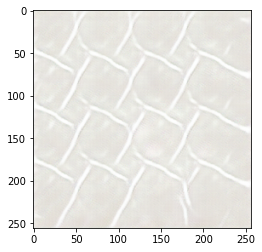

In [72]:
import matplotlib.pyplot as plt
import matplotlib.image as img
  
im = img.imread('./y_gen_100.png')
plt.imshow(im)

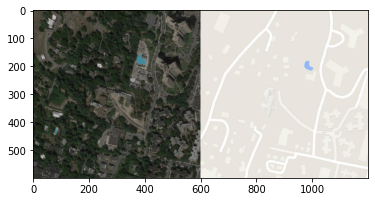

In [73]:
im = img.imread('../input/pix2pix-dataset/maps/maps/train/100.jpg')
plt.imshow(im)